## Runnning with gammapy-dev/IRF_model
Fitting asimov datasets with nuisance parameters based on the different livetimes

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets, FluxPointsDataset
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
    PiecewiseNormSpectralModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator
from gammapy.estimators import FluxPoints, FluxPointsEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys
sys.path.append('../')
import Dataset_load 
from matplotlib import rc
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
from  Dataset_Setup import Setup, GaussianCovariance_matrix

## Read dataset

In [2]:
c = Dataset_load.load_config()
awo, aw, ewo, ew = c['_colors']  

In [3]:
livetimes = c['livetimes']
livetime = c['livetime']
zero = c['zero'] 
norm = c['norm'] 
tilt = c['tilt'] 
bias = c['bias'] 
resolution = c['resolution'] 
magnitude = 10 #c['magnitude'] 
corrlength = c['corrlength']
sys = c['sys'] 
folder = c['folder']
nbidx = 0
sys

'BKG'

In [4]:
def set_up(dataset_input):
    
    setup = Setup(dataset_input=dataset_input)
    #setup.set_up_irf_sys(bias, resolution, norm, tilt)
    dataset_asimov, dataset_asimov_N = setup.run()
    # irf model
    setup.set_irf_model(dataset_asimov_N)
    if sys == "Eff_area":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = True
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
        
        
    if sys == "E_reco":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = True
        dataset_asimov_N.irf_model.parameters['norm'].frozen = True
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)

    if sys == "Combined":
        dataset_asimov_N.models.parameters['resolution'].frozen = True
        dataset_asimov_N.irf_model.parameters['tilt'].frozen = False
        dataset_asimov_N.irf_model.parameters['bias'].frozen = False
        setup.set_irf_prior(dataset_asimov_N, bias, resolution, norm, tilt)
    
    if sys == "BKG":
        
        # piece wise model
        # remove old bkg model
        setup.set_up_bkg_sys_V( breake = 2,
                            index1 = 6,
                            index2 = 0.6, 
                            magnitude = magnitude )
        
        dataset_asimov, dataset_asimov_N = setup.run()
        
        setup.unset_model(dataset_asimov_N, FoVBackgroundModel)
        setup.set_piecewise_bkg_model(dataset_asimov_N)
        #setup.set_piecewise_pl_bkg_model(dataset_asimov_N)
        # energy of the following parameters smaller than ethrshold
        dataset_asimov_N.background_model.parameters['norm0'].frozen = True
        dataset_asimov_N.background_model.parameters['norm1'].frozen = True
        dataset_asimov_N.background_model.parameters['norm2'].frozen = True
        dataset_asimov_N.background_model.parameters['norm3'].frozen = True
        setup.set_bkg_prior(dataset_asimov_N, magnitude, corrlength)
        frozen_pos = 1
        if frozen_pos:
            dataset_asimov.models.parameters['lon_0'].frozen = True
            dataset_asimov.models.parameters['lat_0'].frozen = True
            dataset_asimov_N.models.parameters['lon_0'].frozen = True
            dataset_asimov_N.models.parameters['lat_0'].frozen = True
        else:
            for d in [dataset_asimov, dataset_asimov_N]:
                delta = 0.01 
                dataset_asimov.models.parameters['lon_0'].min = dataset_asimov.models.parameters['lon_0'].value - delta
                dataset_asimov.models.parameters['lon_0'].max = dataset_asimov.models.parameters['lon_0'].value + delta 
                dataset_asimov.models.parameters['lat_0'].min = dataset_asimov.models.parameters['lat_0'].value - delta
                dataset_asimov.models.parameters['lat_0'].max = dataset_asimov.models.parameters['lat_0'].value + delta
                
                
        dataset_asimov_N.models.parameters['_norm'].frozen = False
        #dataset_asimov_N.models.parameters['tilt'].frozen = False
        

    return dataset_asimov_N, dataset_asimov, setup

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-MSH-simulated-100.0-hr.fits.gz
0 100.0
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 135
	total stat : -70501.31

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

DatasetModels

Component 0: SkyModel

  Name                      : msh
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.208   +/-    0.04             
    amplitude                     :   2.49e-12   +/- 2.0e-13 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    320.330       deg         
    lat_0                 (frozen

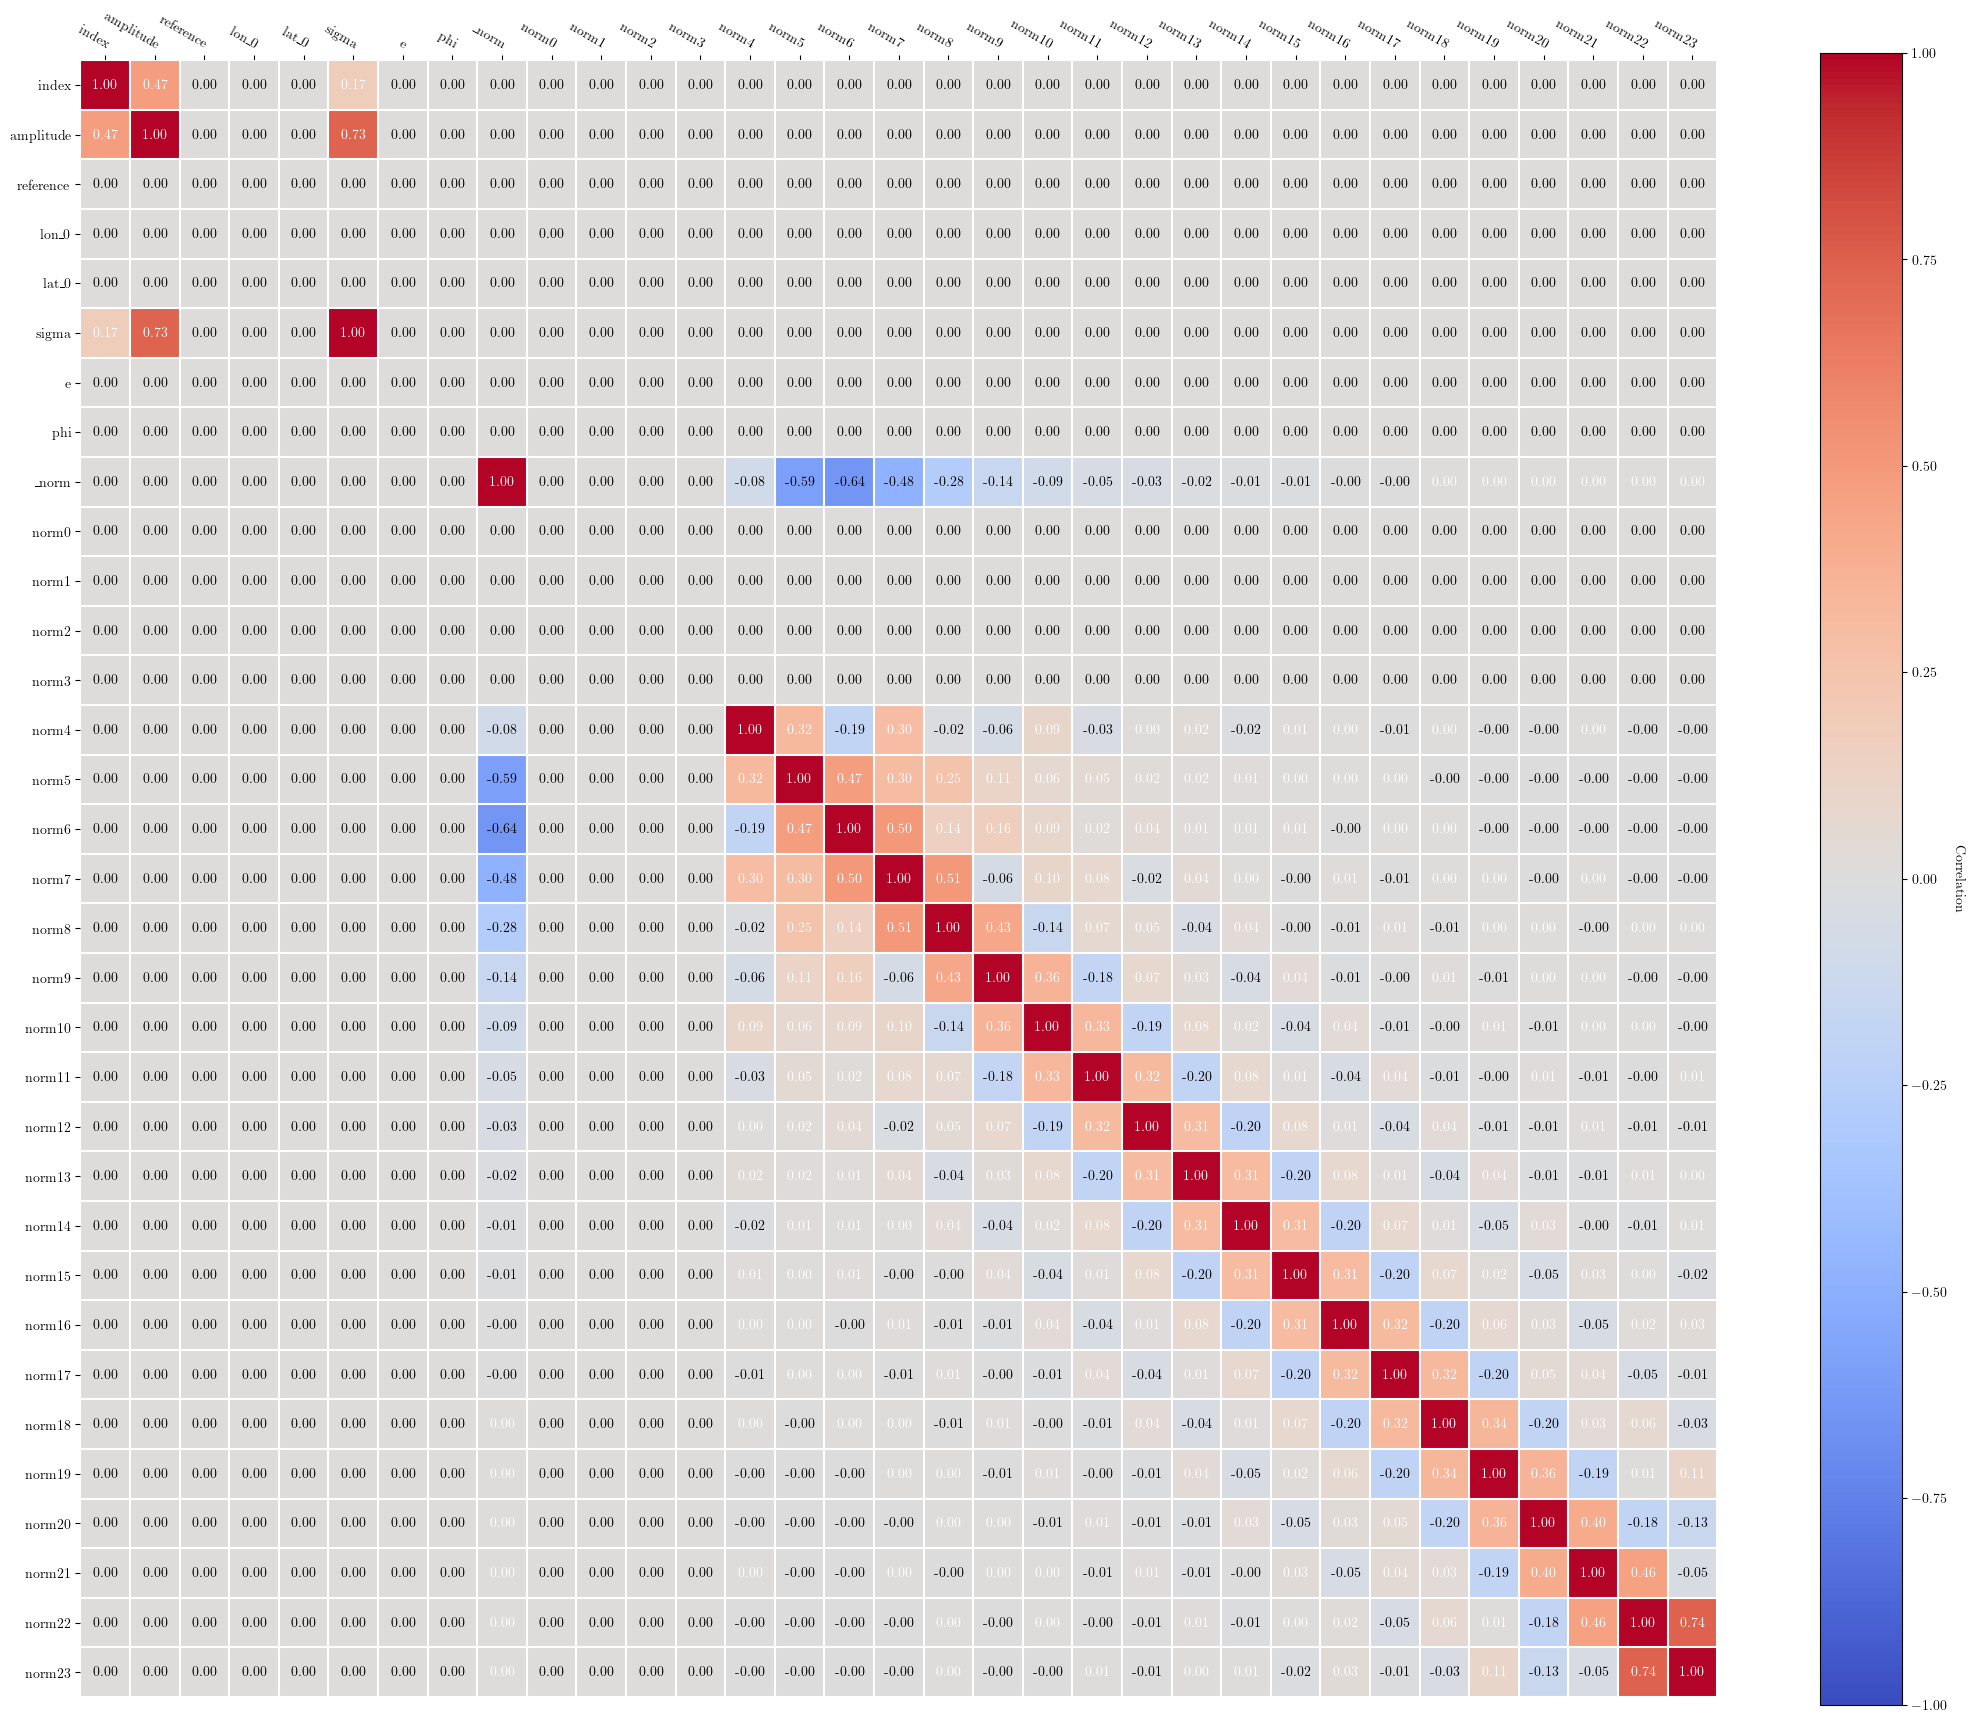

In [5]:
%%time
e_reco_n = 3000
if sys == "Eff_area" or sys == "BKG":
    e_reco_n = 10
    
dw = 1
livetimes = [c['livetime']]#[100.0]
livetimes = [100.0]
fitting_anyting = 1
if fitting_anyting :
    for i,l in enumerate(livetimes):
        datasets_  = Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)
        datasets_i=  datasets_.cutout(datasets_._geom.center_skydir, 
                         (dw, dw) *u.deg, name = datasets_.name)
        datasets_i.models = datasets_.models
        dataset_asimov_N, dataset_asimov, setup = set_up(datasets_i)
        dataset_asimov_N.e_reco_n =e_reco_n

        fitting = 1
        if fitting:
            
            print(i, livetimes[i])
            fit_cor = Fit(store_trace=0)
            minuit_opts = {"tol": 0.1, "strategy": 2}
            fit_cor.backend = "minuit"
            fit_cor.optimize_opts = minuit_opts
            result_cor = fit_cor.run(dataset_asimov)
            print(result_cor)
            print(dataset_asimov.models)
            print("saving")
            path = f'../{folder}/data/0_model_livetime_{livetimes[i]}.yml'
            dataset_asimov.models.write(path,overwrite=True)

        else:
            print(i)

        fitting_N = 1

        if fitting_N:
            if i == 0:
            
                print(i)
                fit_cor_N = Fit(store_trace=0)
                minuit_opts = {"tol": 0.1, "strategy": 2}
                fit_cor_N.backend = "minuit"
                fit_cor_N.optimize_opts = minuit_opts
                result_cor = fit_cor_N.run(dataset_asimov_N)
                print(result_cor)
                print(dataset_asimov_N.models)
                print("saving")
                path = f'../{folder}/data/0_model_nui_livetime_{livetimes[i]}_{e_reco_n}.yml'
                dataset_asimov_N.models.write(path,overwrite=True)

                ax = dataset_asimov_N.models.covariance.plot_correlation()
                plt.savefig(f'../{folder}/plots/0_corr_nui_livetime_{livetimes[i]}_{e_reco_n}.pdf')
        else:
            print(livetimes[i])


else:
    datasets_i =  Dataset_load.create_asimov(model = c['model'], source = c['source'], 
                                                       livetime = f"{l}-hr",
                                                parameters = None)

<WCSAxes: >

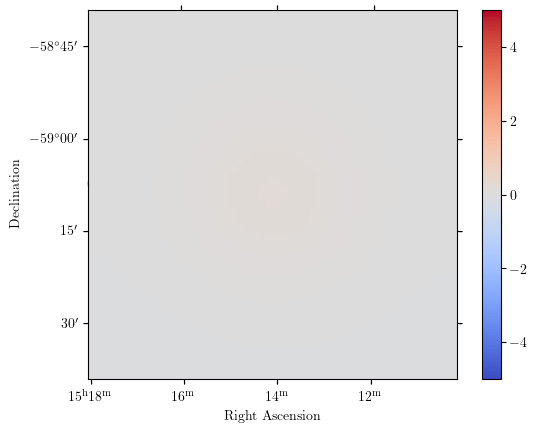

In [6]:
dataset_asimov.plot_residuals_spatial()

<WCSAxes: >

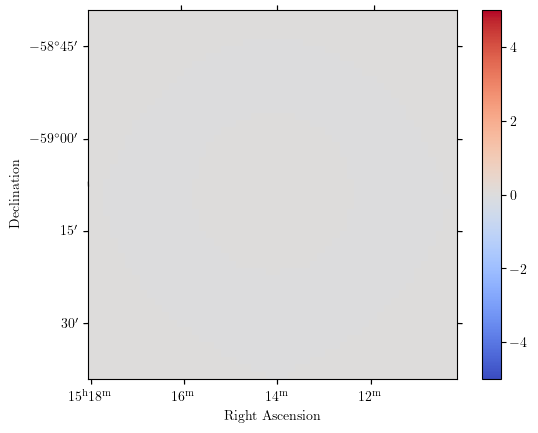

In [7]:
dataset_asimov_N.plot_residuals_spatial()

<WCSAxes: >

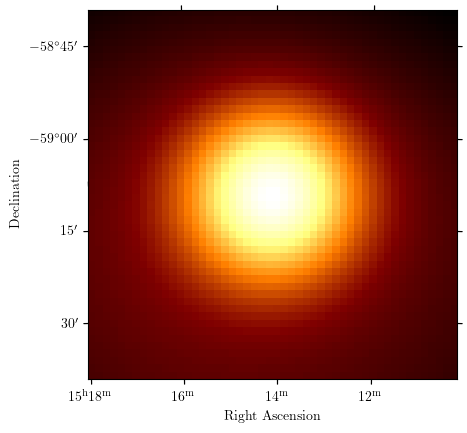

In [8]:
dataset_asimov_N.npred().sum_over_axes().plot()

In [9]:
import colors as l
aw = l.purple
awo =l.orange

labelw = "Fit with background systematic"
labelwo = "Fit without background systematic"


<Axes: xlabel='Reconstructed Energy [TeV]', ylabel='Background Normalisation'>

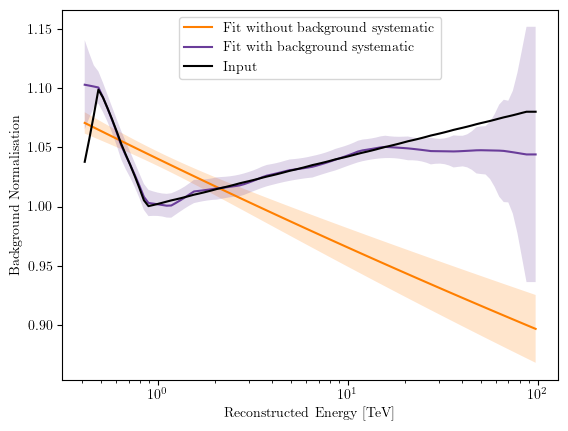

In [10]:

def plot_bkg(ax):
    dataset_asimov.models[1].spectral_model.plot((0.4, 100 ) *u.TeV, color = awo, label = labelwo, ax = ax)
    dataset_asimov.models[1].spectral_model.plot_error((0.4, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo)
    dataset_asimov_N.models[1].spectral_model.plot((0.4, 100 ) *u.TeV,ax = ax, color = aw, label = labelw)
    dataset_asimov_N.models[1].spectral_model.plot_error((0.4, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw,)
    setup.dataset_helper.models[1].spectral_model.plot((0.4, 100 ) *u.TeV,ax = ax, 
                                                      color = 'black', label = "Input")

    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_yscale("linear")
    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.set_ylabel("Background Normalisation")
    
    return ax

fig, ax = plt.subplots(1,1)
plot_bkg(ax)

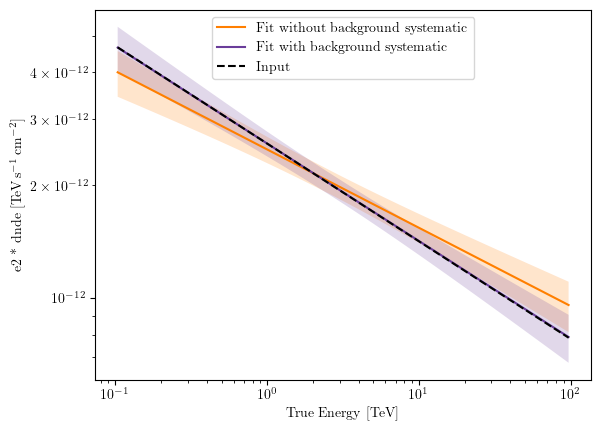

In [11]:

def plot_spec(ax):

    ep = 2
    dataset_asimov.models[0].spectral_model.plot((0.1, 100 ) *u.TeV, energy_power = ep, color = awo,  label = labelwo,ax = ax,)
    dataset_asimov.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                      facecolor = awo, energy_power = ep)
    dataset_asimov_N.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = aw,  label = labelw)
    dataset_asimov_N.models[0].spectral_model.plot_error((0.1, 100 ) *u.TeV,ax = ax,
                                                        facecolor = aw,
                                                        energy_power = ep)
    setup.dataset_helper.models[0].spectral_model.plot((0.1, 100 ) *u.TeV,ax = ax, energy_power = ep, color = 'black', linestyle = 'dashed',
                                                      label = "Input")
    
    ax.legend(loc = 'lower left')
    ax.legend(loc = 'upper center')
    
    ax.set_xlabel("True Energy [TeV]")
    
    
fig, ax = plt.subplots(1,1)
plot_spec(ax)

/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0
shift 1.0


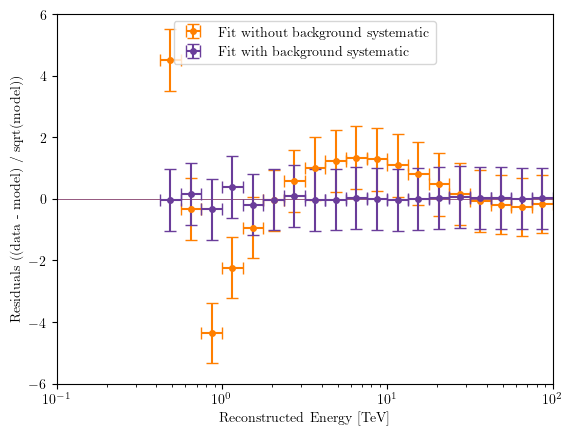

In [12]:
def plot_res(ax):

    dataset_asimov.plot_residuals_spectral(method = 'diff/sqrt(model)', color = awo,ax = ax, capsize = 4, label = labelwo)
    dataset_asimov_N.plot_residuals_spectral(method = 'diff/sqrt(model)', color = aw, ax = ax, capsize = 4, label = labelw)

    ax.set_xlabel("Reconstructed Energy [TeV]")
    ax.legend()
    ax.legend(loc = 'upper center')
    ax.set_ylim(-6,6)
    
fig, ax = plt.subplots(1,1)
plot_res(ax)



/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)
/home/wecapstor1/caph/mppi045h/gammapy/gammapy/datasets/map.py:1158: RuntimeWarning: invalid value encountered in true_divide
  yerr = excess_error / np.sqrt(npred_spec.data)


shift 1.0
shift 1.0


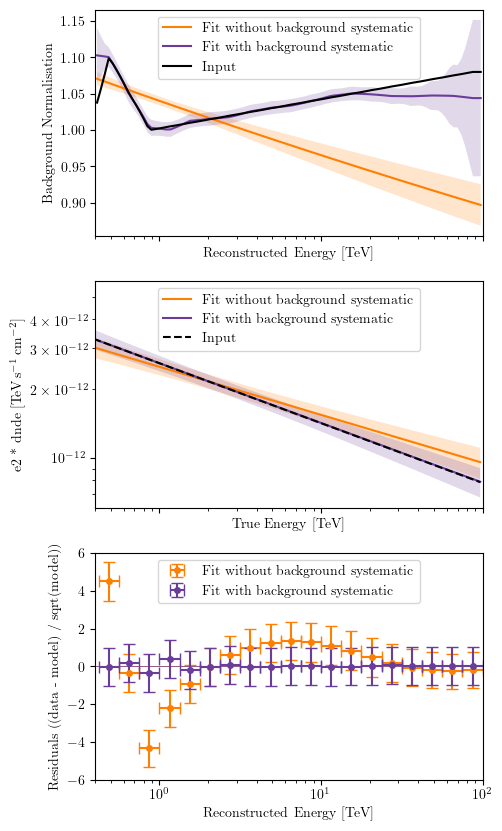

In [13]:
fig, ax = plt.subplots(3,1, figsize = (5,10), sharex = True)


plot_bkg(ax[0])
plot_spec(ax[1])
plot_res(ax[-1])

for a in ax:
    a.set_xlim(0.4, 100)
    
fig.savefig(f'../{folder}/plots/bkg_{livetimes[0]}.pdf', bbox_inches = 'tight')


(0.1, 53150.31839991846)

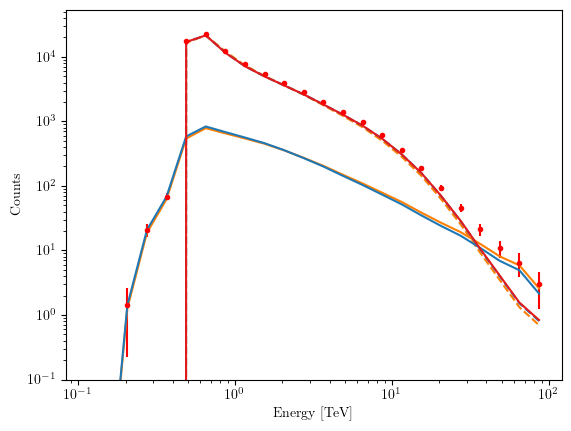

In [14]:
fig, ax = plt.subplots(1,1)
energy = dataset_asimov._geom.axes[0].center.value
ax.errorbar(energy, dataset_asimov.counts.get_spectrum().data.flatten(),
       yerr = np.sqrt(dataset_asimov.counts.get_spectrum().data.flatten()),
           fmt = '.', color = 'red')

ax.plot(energy, dataset_asimov.npred_signal().get_spectrum().data.flatten(),
       color = l.orange 
       )
ax.plot(energy, dataset_asimov.npred_background().get_spectrum().data.flatten(),
        color = l.orange, linestyle = 'dashed'
       )

ax.plot(energy, dataset_asimov_N.npred_signal().get_spectrum().data.flatten(),
       color = l.blue 
       )
ax.plot(energy, dataset_asimov_N.npred_background().get_spectrum().data.flatten(),
        color = l.blue, linestyle = 'dashed'
       )

ax.plot(energy, setup.dataset_helper.npred_background().get_spectrum().data.flatten(),
        color = l.red, linestyle = 'solid'
       )


ax.loglog()
ax.set_xlabel("Energy [TeV]")
ax.set_ylabel("Counts")
ax.set_ylim(0.1,ax.get_ylim()[1])


In [15]:
energy = dataset_asimov._geom.axes[0].center.value[5:]


def flux(map_, dataset):
    map_ = map_.data/ dataset.exposure
    return (map_.sum(axis = 2).sum(axis = 1).flatten()[5:] * energy ** 2)

/tmp/ipykernel_3004374/2461741795.py:5: RuntimeWarning: divide by zero encountered in true_divide
  map_ = map_.data/ dataset.exposure
/tmp/ipykernel_3004374/2461741795.py:5: RuntimeWarning: invalid value encountered in true_divide
  map_ = map_.data/ dataset.exposure


(1e-09, 4.2716965177156627e-07)

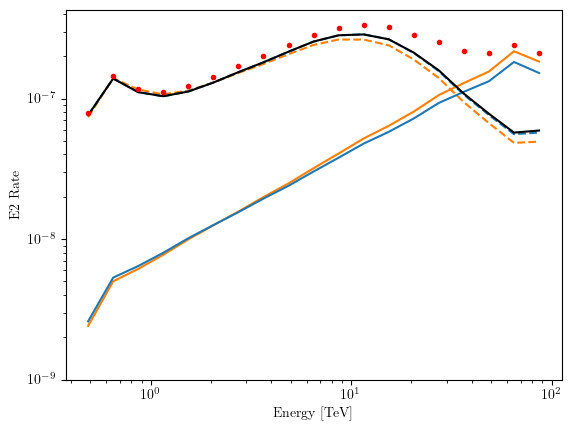

In [16]:
fig, ax = plt.subplots(1,1)
ax.errorbar(energy, flux(dataset_asimov.counts, dataset_asimov),
       #yerr = np.sqrt(flux(dataset_asimov.counts, dataset_asimov)),
           fmt = '.', color = 'red')

ax.plot(energy, flux(dataset_asimov.npred_signal(),dataset_asimov),
       color = l.orange 
       )
ax.plot(energy, flux(dataset_asimov.npred_background(), dataset_asimov),
        color = l.orange, linestyle = 'dashed'
       )

ax.plot(energy, flux(dataset_asimov_N.npred_signal(), dataset_asimov_N),
       color = l.blue 
       )
ax.plot(energy, flux(dataset_asimov_N.npred_background(), dataset_asimov_N),
        color = l.blue, linestyle = 'dashed'
       )

ax.plot(energy, flux(setup.dataset_helper.npred_background(), setup.dataset_helper),
        color = 'black', linestyle = 'solid', )


ax.loglog()
ax.set_xlabel("Energy [TeV]")
ax.set_ylabel("E2 Rate")
ax.set_ylim(1e-9,ax.get_ylim()[1])
#ax.set_xlim(0.4, 100)

In [17]:
label = [ 'input', 'dataset_asimov', 'dataset_asimov_N']
for i, d in enumerate([ setup.dataset_helper, dataset_asimov, dataset_asimov_N]):
    print(label[i])

    for p in ['amplitude','index', 'sigma']:
        par =d.models.parameters[p]
        factor = 1 
        if p == 'amplitude':
            factor = 1e12
        print(f" {p}: ${par.value*factor :.3}  \pm {par.error*factor :.3} $")
    print()

input
 amplitude: $2.58  \pm 0.0 $
 index: $2.26  \pm 0.0 $
 sigma: $0.145  \pm 0.0 $

dataset_asimov
 amplitude: $2.49  \pm 0.2 $
 index: $2.21  \pm 0.0371 $
 sigma: $0.146  \pm 0.00792 $

dataset_asimov_N
 amplitude: $2.58  \pm 0.196 $
 index: $2.26  \pm 0.0362 $
 sigma: $0.145  \pm 0.00747 $



### Minos

In [18]:
minos = False
if minos:
    fit_cor.minuit.minos()
    fit_cor_N.minuit.minos()
    
    for p in fit_cor_N.minuit.parameters:
        p_ = p[8:]
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        dataset_asimov_N.models.parameters[p_].error_n = fit_cor_N.minuit.merrors[p].lower* factor
        dataset_asimov_N.models.parameters[p_].error_p = fit_cor_N.minuit.merrors[p].upper* factor
    dataset_asimov_N.models.write(f'../{folder}/data/0_minos_error_{livetimes[0]}_nui.yaml', overwrite = True)
    
    for p in fit_cor.minuit.parameters:
        p_ = p[8:]
        factor = 1 
        if p_ == "amplitude":
            factor = dataset_asimov.models.parameters['amplitude'].scale
        dataset_asimov.models.parameters[p_].error_n = fit_cor.minuit.merrors[p].lower* factor
        dataset_asimov.models.parameters[p_].error_p = fit_cor.minuit.merrors[p].upper* factor
    dataset_asimov.models.write(f'../{folder}/data/0_minos_error_{livetimes[0]}.yaml', overwrite = True)
    model_N = dataset_asimov_N.models
    model = dataset_asimov.models
    
    
else:
    model_N = Models.read(f'../{folder}/data/0_minos_error_{livetimes[0]}_nui.yaml')    
    model = Models.read(f'../{folder}/data/0_minos_error_{livetimes[0]}.yaml')

In [19]:
unit = "[10^{-12}/\\text{cm}^2 \\text{s} \\text{TeV}] "

print(f" Background & &  $\Phi _0  {unit} $  & $\Lambda$ & $\sigma [^\circ]$ \\\ \hline \hline")

for i, m in enumerate([setup.dataset_helper.models[0],model , model_N]):
    if i == 0:
        str_  = f" & Input &" 
    if i == 1:
        str_  = f" &Without fitting &" 
        
    if i == 2:
        str_  = f" & With fitting  &" 
    for j, p in enumerate(['amplitude', 'index', 'sigma']):
        factor = 1
        if p == 'amplitude':
            factor = 1e12
            
        if i == 0:
            str_  += f" ${ m.parameters[p].value*factor:.5} $  &" 
        if i > 0:
            str_  += " \error {" + f"{m.parameters[p].value*factor:.5}" + '} { ' + f'{m.parameters[p].error*factor:.3}' + '}  {' + f'{m.parameters[p].error_p*factor:.3}' + '}  {' + f'{m.parameters[p].error_n*factor:.3}' +"} &" 
            
    str_ = str_[:-1]
    str_ += "\\\  "
    str_ += "\hline"
    print(f"{str_}")
    str_ = ""
    print()

 Background & &  $\Phi _0  [10^{-12}/\text{cm}^2 \text{s} \text{TeV}]  $  & $\Lambda$ & $\sigma [^\circ]$ \\ \hline \hline
 & Input & $2.58 $  & $2.26 $  & $0.145 $  \\  \hline

 &Without fitting & \error {2.4292} { 0.2}  {0.209}  {-0.196} & \error {2.2184} { 0.0371}  {0.0376}  {-0.037} & \error {0.14278} { 0.00792}  {0.0816}  {-0.078} \\  \hline

 & With fitting  & \error {2.9724} { 0.196}  {0.22}  {-0.205} & \error {2.287} { 0.0362}  {0.0403}  {-0.0389} & \error {0.15656} { 0.00747}  {0.0829}  {-0.0793} \\  \hline

